## Роман Аблизен

### 2ая часть первого дз (непосредствнно 2ая часть начинается чуть ниже, вначале - загрузка и предобработка. Первую часть для удобства удалил)

In [226]:
import pandas as pd
import numpy as np
import seaborn as sns

In [227]:
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import multivariate_normal

In [228]:
sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

## Загружаем и отделяем необходимые нам данные

In [229]:
data = pd.read_csv("owid-covid-data.csv")

In [230]:
data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [231]:
data = data[data.location == 'Russia'][["date","total_cases","new_cases"]]

In [232]:
data["datetime"] = pd.to_datetime(data.date)

In [233]:
data.head()

,date,total_cases,new_cases,datetime
132188,2020-01-31,2.0,2.0,2020-01-31
132189,2020-02-01,2.0,0.0,2020-02-01
132190,2020-02-02,2.0,0.0,2020-02-02
132191,2020-02-03,2.0,0.0,2020-02-03
132192,2020-02-04,2.0,0.0,2020-02-04


In [234]:
data = data[data.datetime >= pd.to_datetime("2020-03-03")] # Отделяем все что раньше 3 марта

In [235]:
data.new_cases[data.new_cases == 0] = 1 # по рекомендации

In [236]:
data = data[["total_cases","new_cases","datetime"]]

In [237]:
data["num"] = [i for i in range(1, len(data) + 1)]

## Непосредственное начало 2ой части

$$y = \int_{-\inf}^{t} \exp\left(at^2 + bt + c\right)dt$$
значит
$$y' = \exp(ax^2+bx+c)$$
$$ln(y') = at^2+bt+c$$

y' - это new_cases

In [238]:
data["num_2"] = data.num ** 2

In [239]:
data.head()

,total_cases,new_cases,datetime,num,num_2
132220,3.0,1.0,2020-03-03,1,1
132221,3.0,1.0,2020-03-04,2,4
132222,4.0,1.0,2020-03-05,3,9
132223,13.0,9.0,2020-03-06,4,16
132224,13.0,1.0,2020-03-07,5,25


In [240]:
x = np.array(data[["num", "num_2"]])
y = np.array(np.log(data.new_cases))
x_test = x[:50,:]
y_test = y[:50].reshape(-1,1)

In [241]:
# a. Обучаем на первых 50 объектах

In [242]:
lr = LinearRegression()
lr.fit(x_test, y_test)
#a = lr.coef_
#b = lr.intercept_
#print("a = ", a[0][0])
#print("b = ", b[0])
print("weights:", lr.coef_)
print("intercept:", lr.intercept_)

weights: [[ 0.27928241 -0.00182979]]
intercept: [-0.67404303]


In [243]:
# Дисперсия шума:

In [244]:
sigma_noise = np.sqrt ( np.sum( (y_test - lr.predict(x_test)) ** 2 ) / len(x_test) )
print(sigma_noise)

0.4891695424595195


In [245]:
# априорное распределение:

In [246]:
cur_mu, cur_sigma = np.array([0, 0, 0]), 2*np.eye(3)

In [247]:
# b. апостериорное распределение:

In [248]:
mu_n, sigma_n = bayesian_update(cur_mu, cur_sigma, x_test, y_test, sigma_noise)

In [249]:
print("апостериорные значения:\n", mu_n)


апостериорные значения:
 [[-0.65815757]
 [ 0.27801196]
 [-0.00180872]]


## Видно, что посчитанные значения хорошо совпадают с коэфф, полученными из линейной регрессии

In [250]:
# c. предсказательное распределение и процентили

In [251]:
from scipy.integrate import cumtrapz as integral

In [252]:
def calc_integral(x, a, b, c):
    f = integral(np.exp(a* x**2 + b*x + c), x)
    return f

In [256]:
# считаем до 1 сентебря (183 день)

In [257]:

def sample_statistics(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]-1))
    for i,w in enumerate(my_w):
        c,b,a = w
        yy = calc_integral(xs, a, b, c)
        res[i,:] = yy
    return res   

In [258]:
xs = np.arange(-100, 183)

In [259]:
res = sample_statistics(mu_n.reshape(3,), sigma_n, xs, n=1000)

In [260]:
c,b,a = mu_n
preds = calc_integral(xs, a, b, c) 
xs = xs[1:]

In [261]:
def plot_predictions(xs, maps, mu, x, points):
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111)
    ax.set_xlim((xs[0], xs[-1]))
    ax.set_ylim((-1e2, 1e7))
    #ax.plot(xs, true_curve(xs), label="Правильный ответ")
    ax.plot(xs, maps, color="red", label="MAP гипотеза")
    #ax.fill_between(xs, np.exp(mu[1]*xs + mu[0] - .25), np.exp(mu[1]*xs + mu[0] + .25), color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(xs, np.mean(x, axis=0) - np.std(x, axis=0), np.mean(x, axis=0) + np.std(x, axis=0), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.scatter(points[0], points[1], marker='*', s=200, label="данные")
    ax.legend(fontsize=legend_fontsize)
    #for i in range(1000):
    #    plt.plot(xs, x[i,:])

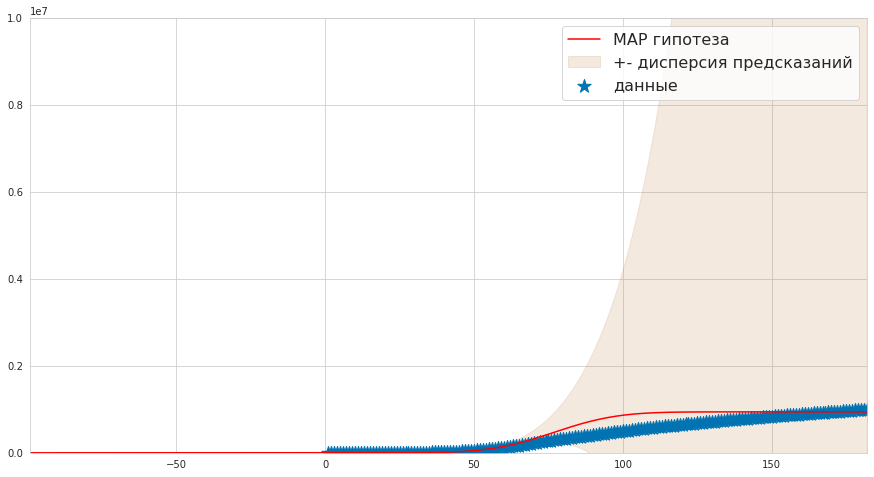

In [262]:
plot_predictions(xs, preds, mu_n.reshape(3,), res, [data.num, data.total_cases])

In [ ]:
# примеры предсказаний для разных значений коэффициентов

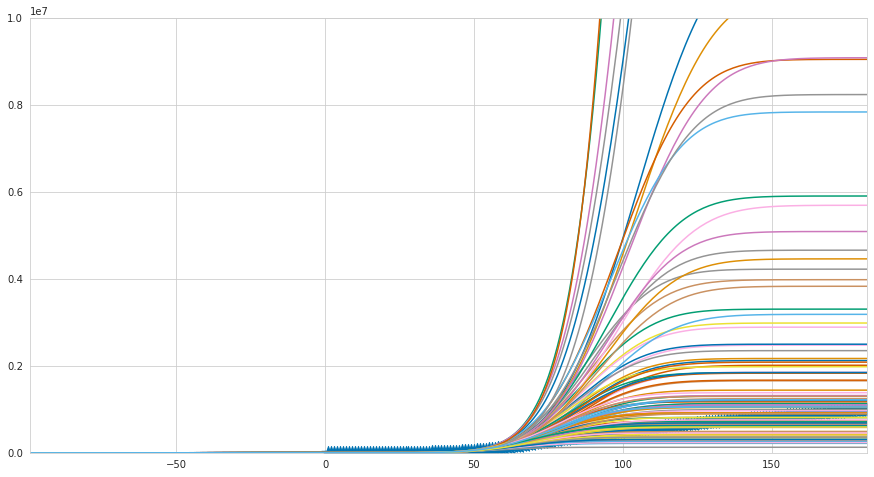

In [263]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-1e2, 1e7))
for i in range(100):
    plt.plot(xs, res[i,:])
    
ax.scatter(data.num, data.total_cases, marker='*', s=200, label="данные")    

### 10 и 90 перцентили

In [264]:
vals = res[:,-1]
print("10-ый перцеинтиль: ", np.percentile(vals, 10))
print("90-ый перцеинтиль: ", np.percentile(vals, 90))

10-ый перцеинтиль:  333039.70154476963
90-ый перцеинтиль:  5828174.56050788
